# User review data processing

I'm going to work through creating embeddings for the text. I'll start off using Tf-Idf as it's simple and easy to implmenet, but may expand to other more complicated embeddings later on.
After the embeddings are created, I'm going to see if I can do some PCA to get an idea of how the reviews differ from eachother. I could also join this up to the companies themselves and see if I can figure out how the companies differ from eachother.

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import NMF, TruncatedSVD
from collections import defaultdict
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk.corpus
import string
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
first_run = False
if first_run:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

In [2]:
review_data = pd.read_csv('yelp_dataset/filtered_reviews_PA.tsv', sep='\t')

In [4]:
review_data = review_data[['review_id', 'stars', 'business_id', 'user_id', 'text']]

In [55]:
review_data.head(3)

,review_id,stars,business_id,user_id,text
0,KU_O5udG6zpxOg-VcAEodg,3.0,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,if you decide to eat here just be aware it is ...
1,AqPFMleE6RsU23_auESxiA,5.0,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,wow yummy different delicious our favorite is ...
2,JrIxlS1TzJ-iCu79ul40cQ,1.0,04UD14gamNjLY0IDYVhHJg,eUta8W_HdHMXPzLBBZhL1A,i am a long term frequent customer of this est...


### Curating stopwords

In [39]:
#Identifying stopwords from multiple sources
my_stopwords = ['review']
nltk_stop_words = list(nltk.corpus.stopwords.words('english'))
nltk_stop_words = [word.translate(str.maketrans('', '', string.punctuation)) for word in nltk_stop_words]
stopwords = list(set(list(ENGLISH_STOP_WORDS) + my_stopwords + nltk_stop_words))

### Adding LemmaTokenizer to lemmatize words

In [41]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

### Initializing tf-idf

TermFrequence = frequency of term in document / total term in document
InverseDocumentFrequence = log(total number of documents / total documents that have the term)

tf-idf = TF(t,d) * IDF(t)

Put another way, a term that appears multiple times in one review, but doesn't appear in other reviews, is particuarly important and is weighted as such.

In [42]:
tf = TfidfVectorizer(strip_accents='unicode',
                     tokenizer=LemmaTokenizer(),
                     stop_words=stopwords,
                     max_features=500)

In [70]:
#NOTE: Could expand to use bi-tri grams

In [56]:
tfidf = tf.fit_transform(review_data['text'])

C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [69]:
# We have 1.2M reviews with 500 features
tfidf.shape

(1203012, 500)

In [75]:
feature_names = tf.get_feature_names_out()
features = tfidf.toarray()

In [180]:
#Checking out one review to see features chosen and tf-idf output
test_review = review_data.iloc[0]['text'].split()

test_review_mapping = np.zeros(len(test_review))
for i in range(len(test_review)):
    feature_index = np.where(feature_names == test_review[i])[0]
    if feature_index.size > 0:
        test_review_mapping[i] = feature_index[0]

test_review_weights = np.zeros(len(test_review_mapping))
for i, index in enumerate(test_review_mapping):
    test_review_weights[i] = features[0][int(index)]  

test_review_output = pd.DataFrame(zip(np.array(test_review), 
                                      test_review_mapping.T, 
                                      test_review_weights.T), 
                                  columns=['word', 'feature_index', 'tf-idf_weight'])
print(test_review_output[test_review_output['feature_index'] != 0].sort_values('tf-idf_weight', ascending=False).drop_duplicates())
print(test_review)

          word  feature_index  tf-idf_weight
85     usually          461.0       0.394302
57        long          253.0       0.351231
47  experience          150.0       0.306584
89       diner          118.0       0.238933
69    pleasant          326.0       0.228738
58        time          440.0       0.215048
20         end          137.0       0.210082
83     waiting          473.0       0.208639
46         bad           31.0       0.172434
15           2            3.0       0.172283
23       tried          449.0       0.170618
29        want          477.0       0.162575
11       going          186.0       0.161800
4          eat          132.0       0.159222
80         way          481.0       0.158528
60        come           88.0       0.140026
96       order          298.0       0.133160
91  restaurant          355.0       0.130884
31        like          243.0       0.112358
51        good          187.0       0.091415
49        food          168.0       0.082975
['if', 'yo

In [198]:
# Classify as good and bad reviews?
svd = TruncatedSVD(n_components=3, random_state=42)
x_svd = svd.fit_transform(features)

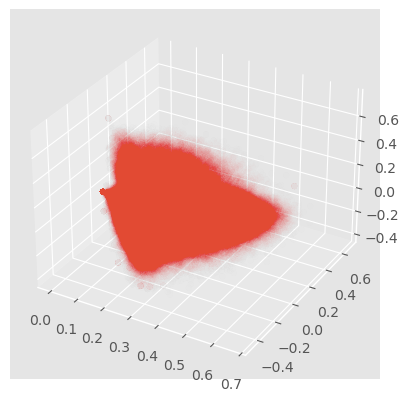

In [203]:
# Nothing to really show here. There aren't clear differences between one type of review
# and another when using SVD on the tf-idf output.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_svd[:,0], x_svd[:,1], x_svd[:,2], alpha=0.002)
plt.show()